# Exploratory Data Analysis for the Main Table (Application_Train)

The goals here are to:
- Load the application_train/test datasets
- Explore Basic EDA (shape, missingness, target distribution, numeric distros, correlations)
- Data cleaning and feature engineering
- Save cleaned train and test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Create Path variables
RAW_DIR = Path("../data/raw")
CLEAN_DIR = Path("../data/clean")

train_path = RAW_DIR / "application_train.csv"
test_path = RAW_DIR / "application_test.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)


Train shape: (307511, 122)
Test shape: (48744, 121)


### 1. Explore Target distribution

TARGET counts:
 TARGET
0    282686
1     24825
Name: count, dtype: int64
Default rate (mean of TARGET): 0.08072881945686496


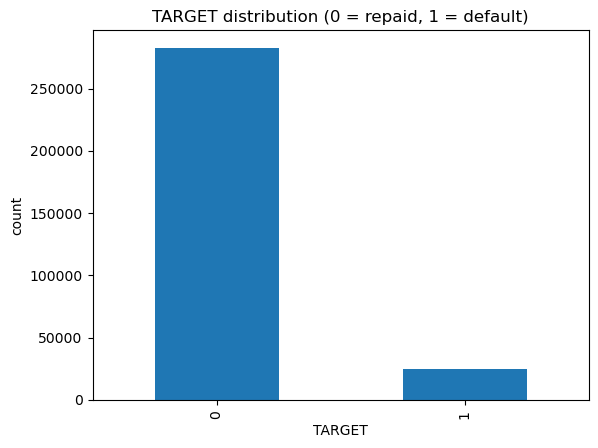

In [3]:
target_counts = train_data["TARGET"].value_counts(dropna=False)
target_rate = train_data["TARGET"].mean()
print("TARGET counts:\n", target_counts)
print("Default rate (mean of TARGET):", target_rate)

target_counts.plot(kind="bar")
plt.title("TARGET distribution (0 = repaid, 1 = default)")
plt.xlabel("TARGET")
plt.ylabel("count")
plt.show()


### 2. Explore Missing values

Top 20 missing in TRAIN:


,missing_frac,missing_pct
COMMONAREA_MEDI,0.698723,69.872297
COMMONAREA_AVG,0.698723,69.872297
COMMONAREA_MODE,0.698723,69.872297
NONLIVINGAPARTMENTS_MODE,0.694330,69.432963
NONLIVINGAPARTMENTS_AVG,0.694330,69.432963
NONLIVINGAPARTMENTS_MEDI,0.694330,69.432963
FONDKAPREMONT_MODE,0.683862,68.386172
LIVINGAPARTMENTS_MODE,0.683550,68.354953
LIVINGAPARTMENTS_AVG,0.683550,68.354953
LIVINGAPARTMENTS_MEDI,0.683550,68.354953


Top 20 missing in TEST:


,missing_frac,missing_pct
COMMONAREA_AVG,0.687161,68.716150
COMMONAREA_MODE,0.687161,68.716150
COMMONAREA_MEDI,0.687161,68.716150
NONLIVINGAPARTMENTS_AVG,0.684125,68.412523
NONLIVINGAPARTMENTS_MODE,0.684125,68.412523
NONLIVINGAPARTMENTS_MEDI,0.684125,68.412523
FONDKAPREMONT_MODE,0.672842,67.284179
LIVINGAPARTMENTS_AVG,0.672493,67.249302
LIVINGAPARTMENTS_MODE,0.672493,67.249302
LIVINGAPARTMENTS_MEDI,0.672493,67.249302


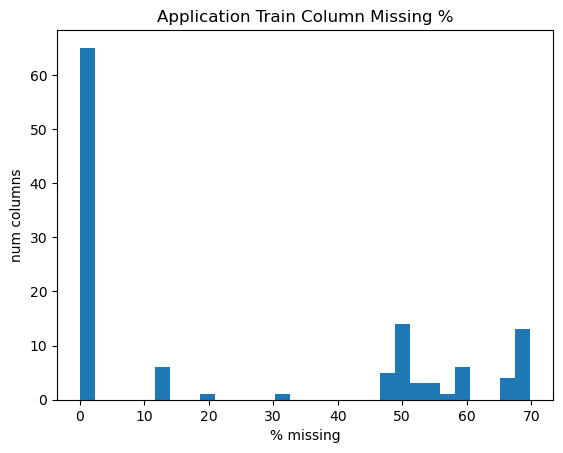

In [4]:
def missing_summary(df, top_n=20):
    mis = df.isnull().mean().sort_values(ascending=False)
    out = mis.to_frame("missing_frac").assign(missing_pct=lambda x: x["missing_frac"]*100)
    return out.head(top_n)

print("Top 20 missing in TRAIN:")
display(missing_summary(train_data, 20))

print("Top 20 missing in TEST:")
display(missing_summary(test_data, 20))

plt.hist(train_data.isnull().mean()*100, bins=30)
plt.title("Application Train Column Missing %")
plt.xlabel("% missing")
plt.ylabel("num columns")
plt.show()


### 3. Explore Numeric feature distributions vs TARGET

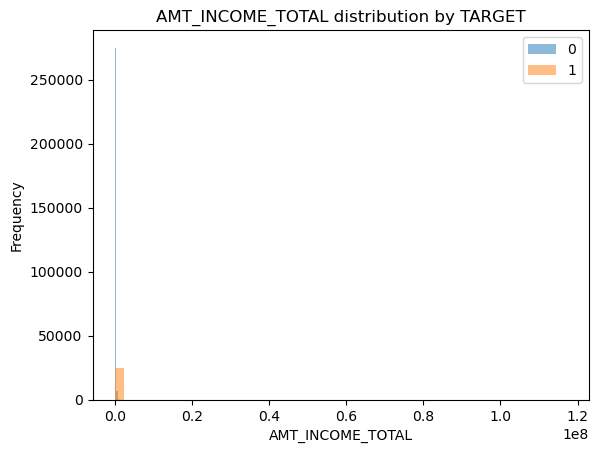

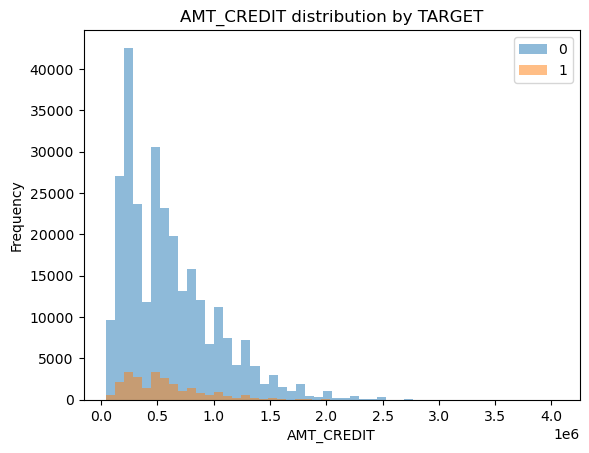

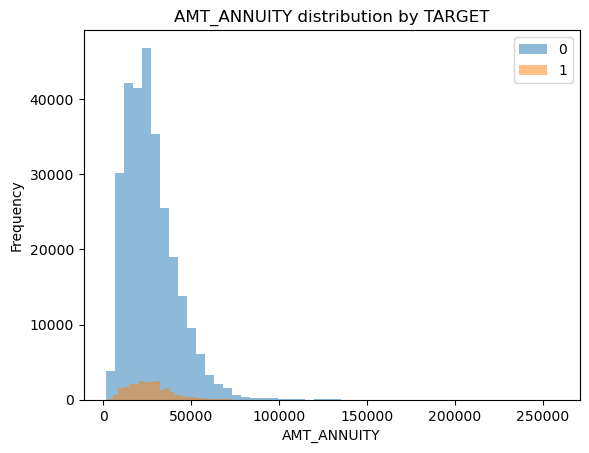

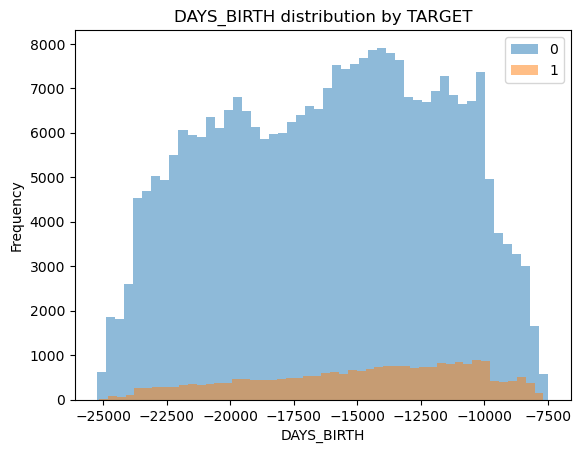

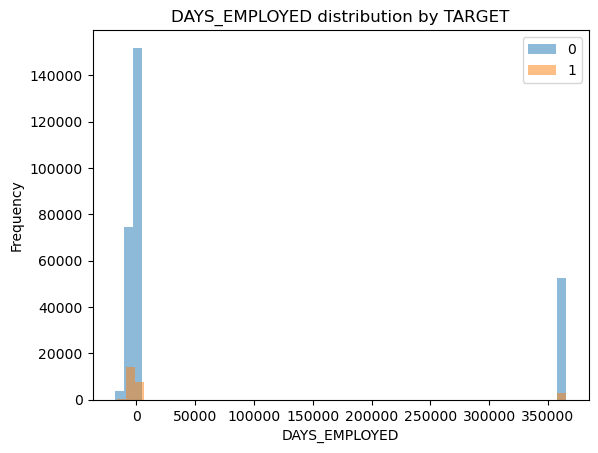

In [5]:
numeric_cols_focus = [
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED"
]
for col in numeric_cols_focus:
    if col in train_data.columns:
        plt.figure()
        train_data.groupby("TARGET")[col].plot(kind="hist", bins=50, alpha=0.5, legend=True)
        plt.title(f"{col} distribution by TARGET")
        plt.xlabel(col)
        plt.show()


### 4. Target Correlation for Numeric features

Top 15 abs corr with TARGET:


EXT_SOURCE_3                  -0.178919
EXT_SOURCE_2                  -0.160472
EXT_SOURCE_1                  -0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
DAYS_EMPLOYED                 -0.044932
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
FLOORSMAX_AVG                 -0.044003
FLOORSMAX_MEDI                -0.043768
dtype: float64

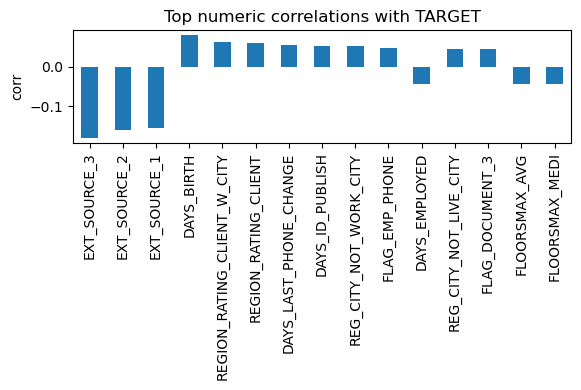

In [7]:
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_no_id = [c for c in numeric_cols if c not in ["SK_ID_CURR", "TARGET"]]
corrs = (
    train_data[numeric_cols_no_id]
    .corrwith(train_data["TARGET"])
    .sort_values(key=lambda s: s.abs(), ascending=False)
)
print("Top 15 abs corr with TARGET:")
display(corrs.head(15))

plt.figure(figsize=(6,4))
corrs.head(15).plot(kind="bar")
plt.title("Top numeric correlations with TARGET")
plt.ylabel("corr")
plt.tight_layout()
plt.show()


### 5. Perform data quality checks
- Duplicates on SK_ID_CURR which is the foreign key



In [8]:
dup_counts = train_data["SK_ID_CURR"].duplicated().sum()
print("Duplicate SK_ID_CURR in train:", dup_counts)

dup_counts_test = test_data["SK_ID_CURR"].duplicated().sum()
print("Duplicate SK_ID_CURR in test:", dup_counts_test)

if "DAYS_EMPLOYED" in train_data.columns:
    print("Unique DAYS_EMPLOYED top 5:", train_data["DAYS_EMPLOYED"].value_counts().head())

if "CNT_FAM_MEMBERS" in train_data.columns:
    print("CNT_FAM_MEMBERS describe:", train_data["CNT_FAM_MEMBERS"].describe())


Duplicate SK_ID_CURR in train: 0
Duplicate SK_ID_CURR in test: 0
Unique DAYS_EMPLOYED top 5: DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
Name: count, dtype: int64
CNT_FAM_MEMBERS describe: count    307509.000000
mean          2.152665
std           0.910682
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          20.000000
Name: CNT_FAM_MEMBERS, dtype: float64


### Feature Engineering on application data


In [10]:
def engineer_application_features(df: pd.DataFrame, is_train=True) -> pd.DataFrame:
    out = df.copy()

    # replace 365243 in DAYS_EMPLOYED with NaN (placeholder for unemployed)
    if "DAYS_EMPLOYED" in out.columns:
        out["DAYS_EMPLOYED_REPLACED"] = out["DAYS_EMPLOYED"].replace({365243: np.nan})

    safe_div_children = lambda income, kids: income / np.where(kids==0, 1, kids)

    if set(["AMT_CREDIT","AMT_INCOME_TOTAL"]).issubset(out.columns):
        out["CREDIT_INCOME_PERCENT"] = out["AMT_CREDIT"] / out["AMT_INCOME_TOTAL"]

    if set(["AMT_ANNUITY","AMT_INCOME_TOTAL"]).issubset(out.columns):
        out["ANNUITY_INCOME_PERCENT"] = out["AMT_ANNUITY"] / out["AMT_INCOME_TOTAL"]

    if set(["AMT_CREDIT","AMT_ANNUITY"]).issubset(out.columns):
        out["CREDIT_ANNUITY_PERCENT"] = out["AMT_CREDIT"] / out["AMT_ANNUITY"]

    if set(["AMT_INCOME_TOTAL","CNT_FAM_MEMBERS"]).issubset(out.columns):
        out["FAMILY_CNT_INCOME_PERCENT"] = out["AMT_INCOME_TOTAL"] / out["CNT_FAM_MEMBERS"].replace({0:np.nan})

    if set(["AMT_ANNUITY","AMT_CREDIT"]).issubset(out.columns):
        out["CREDIT_TERM"] = out["AMT_ANNUITY"] / out["AMT_CREDIT"]

    if set(["DAYS_EMPLOYED","DAYS_BIRTH"]).issubset(out.columns):
        out["BIRTH_EMPLOYED_PERCENT"] = out["DAYS_EMPLOYED"] / out["DAYS_BIRTH"]

    if set(["AMT_INCOME_TOTAL","CNT_CHILDREN"]).issubset(out.columns):
        out["CHILDREN_CNT_INCOME_PERCENT"] = safe_div_children(out["AMT_INCOME_TOTAL"], out["CNT_CHILDREN"])

    if set(["AMT_CREDIT","AMT_GOODS_PRICE"]).issubset(out.columns):
        out["CREDIT_GOODS_DIFF"] = out["AMT_CREDIT"] - out["AMT_GOODS_PRICE"]

    if set(["DAYS_EMPLOYED","DAYS_REGISTRATION"]).issubset(out.columns):
        out["EMPLOYED_REGISTRATION_PERCENT"] = out["DAYS_EMPLOYED"] / out["DAYS_REGISTRATION"]

    # YEARS features
    def to_years(col):
        return (-col / 365).astype(float)

    if "DAYS_BIRTH" in out.columns:
        out["YEARS_BIRTH"] = to_years(out["DAYS_BIRTH"])

    if "DAYS_EMPLOYED_REPLACED" in out.columns:
        out["YEARS_EMPLOYED"] = (-out["DAYS_EMPLOYED_REPLACED"] / 365).clip(lower=0, upper=60)

    if "DAYS_ID_PUBLISH" in out.columns:
        out["YEARS_ID_PUBLISH"] = to_years(out["DAYS_ID_PUBLISH"])

    if "DAYS_REGISTRATION" in out.columns:
        out["YEARS_REGISTRATION"] = to_years(out["DAYS_REGISTRATION"])

    if "DAYS_LAST_PHONE_CHANGE" in out.columns:
        out["YEARS_LAST_PHONE_CHANGE"] = to_years(out["DAYS_LAST_PHONE_CHANGE"])

    return out

train_data_fe = engineer_application_features(train_data)
test_data_fe = engineer_application_features(test_data, is_train=False)

print("Engineered train shape:", train_data_fe.shape)
print("Engineered test shape:", test_data.shape)


Engineered train shape: (307511, 137)
Engineered test shape: (48744, 121)


#### Normalize Y/N binary flags to 0/1

In [11]:
def normalize_binary_flags(df):
    out = df.copy()
    for col in out.columns:
        if out[col].dtype == object:
            vals = set(out[col].dropna().unique().tolist())
            if vals.issubset({'Y','N'}):
                out[col] = out[col].map({'Y':1,'N':0})
    return out

train_data_fe = normalize_binary_flags(train_data_fe)
test_data_fe = normalize_binary_flags(test_data_fe)


## Save interim cleaned versions of application-level data

In [13]:
train_out_path = CLEAN_DIR / "application_train_fe.csv"
test_out_path = CLEAN_DIR / "application_test_fe.csv"

train_data_fe.to_csv(train_out_path, index=False)
test_data_fe.to_csv(test_out_path, index=False)

print(f"Saved {train_out_path}")
print(f"Saved {test_out_path}")


Saved ../data/clean/application_train_fe.csv
Saved ../data/clean/application_test_fe.csv
